In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib as mpl
import time

## An example of non-staggered grid implementation

Implemented with the help of an LLM

In [5]:
def div(vel_x, vel_y, pos_x, pos_y):
    """
    Compute the velocity divergence field at all grid points.
    
    On a collocated grid, both velocity components are stored at the same grid points.
    The divergence is computed as: ∇·u = ∂u_x/∂x + ∂u_y/∂y
    
    Uses central differences: ∂u/∂x ≈ (u[i,j+1] - u[i,j-1]) / 2
    Boundary values are clipped to avoid out-of-bounds access.
    
    Args:
        vel_x: 2D array of horizontal velocity components
        vel_y: 2D array of vertical velocity components
        pos_x: 2D array of x-coordinates (used for clipping)
        pos_y: 2D array of y-coordinates (used for clipping)
    
    Returns:
        2D array of divergence values at each grid point
    """
    global size
    pos_x = np.clip(pos_x, 1, size-2).astype(np.int32)
    pos_y = np.clip(pos_y, 1, size-2).astype(np.int32)

    dvel_x_dx = (vel_x[pos_y, pos_x + 1] - vel_x[pos_y, pos_x - 1]) / 2
    dvel_y_dy = (vel_y[pos_y + 1, pos_x] - vel_y[pos_y - 1, pos_x]) / 2
    return dvel_x_dx+dvel_y_dy


def neighbour_pressure(P, pos_x, pos_y):
    """
    Extract the four neighboring pressure values (up, right, down, left) at each grid point.
    
    This is used in the Jacobi iteration for solving the pressure Poisson equation:
    P_new = (P_neighbors_sum - divergence) / 4
    
    Which approximates: ∇²P = (∂²P/∂x² + ∂²P/∂y²) ≈ divergence
    
    Args:
        P: 2D array of pressure values
        pos_x: 2D array of x-coordinates (for clipping)
        pos_y: 2D array of y-coordinates (for clipping)
    
    Returns:
        2D array of summed neighboring pressure values
    """
    pos_x = np.clip(pos_x, 1, size-2).astype(np.int32)
    pos_y = np.clip(pos_y, 1, size-2).astype(np.int32)
    return P[pos_y+1, pos_x] + P[pos_y, pos_x+1] + P[pos_y-1, pos_x] + P[pos_y, pos_x-1]


def gradient(P, x_indices, y_indices):
    """
    Compute the pressure gradient field at all grid points.
    
    The gradient is computed as: ∇P = (∂P/∂x, ∂P/∂y)
    
    Uses central differences on the collocated grid:
    ∂P/∂x ≈ (P[i,j+1] - P[i,j-1]) / 2
    ∂P/∂y ≈ (P[i+1,j] - P[i-1,j]) / 2
    
    Args:
        P: 2D array of pressure values
        x_indices: 2D array of x-coordinate indices
        y_indices: 2D array of y-coordinate indices
    
    Returns:
        Tuple (grad_x, grad_y) of pressure gradient components
    """
    
    size_x = len(x_indices[0])
    size_y = len(y_indices.T[1])

    x_clipped = np.clip(x_indices, 1, size_x-2).astype(np.int32)
    y_clipped = np.clip(y_indices, 1, size_y-2).astype(np.int32)

    grad_x = (P[y_clipped, x_clipped+1] - P[y_clipped, x_clipped-1]) / 2
    grad_y = (P[y_clipped+1, x_clipped] - P[y_clipped-1, x_clipped]) / 2
    return grad_x, grad_y


def bilinear(vel_x, vel_y, prev_pos_x, prev_pos_y):
    """
    Semi-Lagrangian advection using bilinear interpolation for velocity.
    
    For each grid point, trace backward along the velocity field to find the
    departure point, then interpolate the velocity at that point using bilinear
    interpolation. This brings velocity from upstream positions to the current grid.
    
    Semi-Lagrangian advection is unconditionally stable (CFL condition not required).
    
    Args:
        vel_x: 2D array of horizontal velocity to advect
        vel_y: 2D array of vertical velocity to advect
        prev_pos_x: 2D array of backward-traced x-coordinates
        prev_pos_y: 2D array of backward-traced y-coordinates
    
    Returns:
        Tuple (vel_x_new, vel_y_new) of advected velocity fields
    """
    
    prev_pos_x = np.clip(prev_pos_x, 0, size-1.0001)
    prev_pos_y = np.clip(prev_pos_y, 0, size-1.0001)
    
    x0 = np.floor(prev_pos_x).astype(np.int32)
    x1 = np.ceil(prev_pos_x).astype(np.int32)
    y0 = np.floor(prev_pos_y).astype(np.int32)
    y1 = np.ceil(prev_pos_y).astype(np.int32)

    fx = prev_pos_x - x0
    fy = prev_pos_y - y0

    vel_x_new = (
        vel_x[y0, x0]*(1-fx)*(1-fy) +
        vel_x[y1, x0]*(1-fx)*fy +
        vel_x[y0, x1]*fx*(1-fy) +
        vel_x[y1, x1]*fx*fy
    )
    vel_y_new = (
        vel_y[y0, x0]*(1-fx)*(1-fy) +
        vel_y[y1, x0]*(1-fx)*fy +
        vel_y[y0, x1]*fx*(1-fy) +
        vel_y[y1, x1]*fx*fy
    )

    vel_x = vel_x_new
    vel_y = vel_y_new
    return vel_x, vel_y
    

def bilinear_field(field, prev_pos_x, prev_pos_y, solid_mask=None):
    
    """
    Semi-Lagrangian advection using bilinear interpolation for scalar fields.
    
    Similar to bilinear() but for scalar fields (e.g., smoke density).
    Traces backward, interpolates the scalar at departure point, and applies
    optional masking (e.g., to zero out smoke inside solid objects).
    
    Args:
        field: 2D array of scalar field to advect (e.g., smoke density)
        prev_pos_x: 2D array of backward-traced x-coordinates
        prev_pos_y: 2D array of backward-traced y-coordinates
        solid_mask: Optional 2D boolean mask; True values are zeroed in output
    
    Returns:
        2D array of advected scalar field
    """

    prev_pos_x = np.clip(prev_pos_x, 0, size-1.0001)
    prev_pos_y = np.clip(prev_pos_y, 0, size-1.0001)
    
    x0 = np.floor(prev_pos_x).astype(np.int32)
    x1 = np.ceil(prev_pos_x).astype(np.int32)
    y0 = np.floor(prev_pos_y).astype(np.int32)
    y1 = np.ceil(prev_pos_y).astype(np.int32)
    
    fx = prev_pos_x - x0
    fy = prev_pos_y - y0
    
    field_new = (
        field[y0, x0]*(1-fx)*(1-fy) +
        field[y1, x0]*(1-fx)*fy +
        field[y0, x1]*fx*(1-fy) +
        field[y1, x1]*fx*fy
    )

    if solid_mask is not None:
        field_new[solid_mask] = 0

    return field_new

Simulation: 48.92 seconds


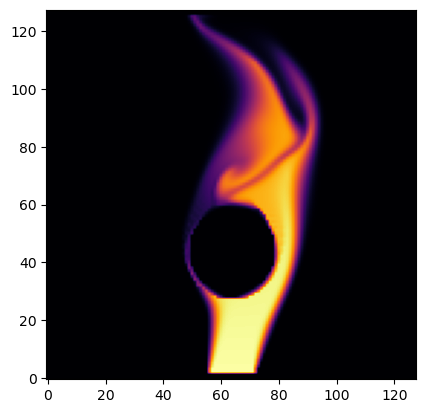

In [ ]:
fps = 30                               # Frames per second for animation output
dt = 0.1                               # Time step size for simulation updates
duration = 20                          # Total simulation duration in seconds
frames = int(fps * duration)           # Total number of frames in the animation
size = 128                             # Grid resolution (size x size)
N_iters = 50                           # Number of pressure solver iterations for incompressibility
random_force_strength = 20             # Magnitude of random external forces (if enabled)
border_fading = 0                      # Edge smoke fade factor (0 = no fading)

grad_scale = 1                         # Pressure gradient scaling factor

smoke = np.zeros((size, size))         # Scalar smoke density field
vel_x = np.zeros((size, size))         # Velocity field x-component
vel_y = np.zeros((size, size))         # Velocity field y-component
P = np.zeros((size, size))             # Pressure field

pos_x, pos_y = np.meshgrid(np.arange(size), np.arange(size))  # Grid coordinates for field sampling

fig, ax = plt.subplots()               # Create Matplotlib figure and axis
im = ax.imshow(smoke, origin='lower', cmap='inferno', vmin=0, vmax=1)  # Smoke visualization setup

radius = 15                            # Radius of the solid obstacle
cx, cy = size // 2, size // 2 - 20     # Center coordinates of the solid obstacle

x, y = np.meshgrid(np.arange(size), np.arange(size))           # Coordinate grid arrays
solid_mask = (x - cx)**2 + (y - cy)**2 < radius**2             # Boolean mask for solid region

dx = x - cx
dy = y - cy
dist = np.sqrt(dx**2 + dy**2) + 1e-6
nx, ny = dx / dist, dy / dist           # Unit normal vectors at each grid point
boundary_mask = np.abs(dist - radius) < 2  # Boolean mask for solid boundary points

start_time = time.time()
def update(frame):
    """
    Main simulation step for each frame.
    
    Implements a fractional-step incompressible Navier-Stokes solver on a COLLOCATED grid.
    The algorithm proceeds as:
    
    1. ADVECTION: Semi-Lagrangian advection of velocity field (unconditionally stable)
    
    2. PRESSURE PROJECTION: 
       - Compute divergence of advected velocity
       - Solve Poisson equation: ∇²P ≈ divergence using Jacobi iteration
         P_new = (sum of 4 neighbors - divergence) / 4
       - Subtract pressure gradient from velocity to enforce incompressibility
    
    3. BOUNDARY CONDITIONS:
       - Remove normal component of velocity at solid surface (no-penetration)
       - Apply external push force outward from solid surface
    
    4. SOURCE TERMS: Add smoke and upward velocity at domain source
    
    5. DISSIPATION: Apply velocity and smoke damping for stability
    
    NOTE: This is a COLLOCATED (non-staggered) grid implementation.
    All fields (velocity, pressure, scalar) are stored at the same grid points.
    This arrangement is less stable than staggered grids and can produce pressure
    checkerboard oscillations, but works adequately with sufficient Jacobi iterations
    and artificial dissipation.
    """
    global smoke, vel_x, vel_y, P

    prev_pos_x = pos_x - vel_x * dt
    prev_pos_y = pos_y - vel_y * dt
    vel_x, vel_y = bilinear(vel_x, vel_y, prev_pos_x, prev_pos_y)

    #F_x = gaussian_filter((np.random.rand(size, size) - 0.5), sigma=3) * random_force_strength
    #F_y = gaussian_filter((np.random.rand(size, size) - 0.5), sigma=3) * random_force_strength
    #vel_x += F_x * dt
    #vel_y += F_y * dt

    divergence = div(vel_x, vel_y, pos_x, pos_y)
    
    for _ in range(N_iters):
        P_new = (neighbour_pressure(P, pos_x, pos_y) - divergence) / 4
        P = 0.8 * P + 0.2 * P_new

    gx, gy = gradient(P, pos_x, pos_y)
    vel_x -= grad_scale * gx
    vel_y -= grad_scale * gy

    smoke[solid_mask] = 0
    
    
    vn = vel_x * nx + vel_y * ny                 #Kiirus skalaari suunas
    vel_x[boundary_mask] -= vn[boundary_mask] * nx[boundary_mask] #Eemaldab normaalisuunalise kiiruse kogu kiirusest, ehk keelab sisse liikumist
    vel_y[boundary_mask] -= vn[boundary_mask] * ny[boundary_mask]
    vel_x[solid_mask] =0
    vel_x[solid_mask] =0

    push_strength = 4.0
    vel_x[boundary_mask] += nx[boundary_mask] * push_strength * dt
    vel_y[boundary_mask] += ny[boundary_mask] * push_strength * dt
    
    source_height = 2 #mitte väiksem kui border
    source_strength = 1
    vel_upward = 25.0
    source_width = 8
    center = size // 2
    smoke[:source_height, center - source_width:center + source_width] += source_strength
    #smoke = np.clip(smoke, 0, 1)
    vel_y[:source_height, center - source_width:center + source_width] = vel_upward

    smoke = bilinear_field(smoke, pos_x - vel_x*dt, pos_y - vel_y*dt, solid_mask=solid_mask)
    smoke *= 0.998
    smoke[solid_mask] = 0


    border = 2
    smoke[:border, :] *= border_fading
    smoke[-border:, :] *= border_fading
    smoke[:, :border] *= border_fading
    smoke[:, -border:] *= border_fading
    
    im.set_data(smoke)
    return [im]

ani = FuncAnimation(
    fig,          # The figure to animate
    update,       # The function that updates each frame
    frames=frames,# Total number of frames
    interval=30,  # Time between frames in milliseconds
    blit=True     # Only redraw the parts that have changed
)
writer = FFMpegWriter(fps=fps)
ani.save("smoke.mp4", writer=writer)

end_time = time.time()
print(f"Simulation: {end_time - start_time:.2f} seconds")